# GOAL: Extract information

| Category | Key | Value |
|----------|-----|-------|
| Employer Information | Employer Name | Northstar Analytics LLC |
| Employer Information | Employer Phone | 415-555-0198 |
| Employer Information | Employer Address | 250 Market Street, San Francisco, CA 94105 |
| Employee Information | Employee Name | Alex Johnson |
| Employee Information | Employee # | 78412 |
| Employee Information | Employee Address | 890 Pine Ave, Austin, TX 78701 |
| Employee Information | Department | 200045-Data Platforms |
| Employee Information | Job Title | Senior Data Engineer |
| Employee Information | Manager | Maria Lopez |
| Payroll Details | Pay Date | 02/07/2026 |
| Payroll Details | Pay Period | 01/25/2026 - 02/07/2026 |
| Payroll Details | Deposit Advice # | 99234711 |
| Payroll Details | Pay Frequency | Bi-Weekly |
| Payroll Details | Pay Rate | $6,450.00 |
| Earnings | Regular Pay Hours | 80.00 |
| Earnings | Regular Pay Rate | $80.63 |
| Earnings | Regular Pay Amount | $6,450.00 |
| Earnings | Holiday Pay Hours | 16.00 |
| Earnings | Holiday Pay Rate | $80.63 |
| Earnings | Holiday Pay Amount | $1,290.08 |
| Pre-Tax Deductions | Total Pre-Tax Deductions | $520.40 |
| Pre-Tax Deductions | 401(k) | $410.00 |
| Pre-Tax Deductions | Medical | $95.40 |
| Pre-Tax Deductions | Dental | $15.00 |
| Taxes | Federal Withholding | $910.50 |
| Taxes | FICA | $385.30 |
| Taxes | State Withholding (TX) | $0.00 |
| Net Pay | Net Pay Amount | $5,924.28 |
| Distribution | Bank Routing # | 021000021 |
| Distribution | Bank Account # | XXXXXXXX4481 |
| System Info | Platform | Earnings - Dayforce |

## Set Data Dir

In [7]:
from pathlib import Path
# Create data directory
data_dir = Path("mock_data_extraction")
data_dir.mkdir(exist_ok=True)

### Bounding Box Utility Functions

These functions help visualize extraction results by finding and drawing bounding boxes around extracted fields.

In [8]:
import fitz  # PyMuPDF
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from typing import List, Tuple, Optional, Union, Dict
from docling.document_converter import DocumentConverter
from IPython.display import display

def find_text_bounding_boxes(
    doc_result,
    search_texts: List[str],
    page_filter: Optional[int] = None
) -> Dict[str, List[Dict]]:
    """
    Find bounding boxes for specific text strings in a converted document.
    
    Args:
        doc_result: DocumentConverter result object
        search_texts: List of text strings to find
        page_filter: Optional page number to limit search
    
    Returns:
        Dictionary mapping search text to list of matches with bbox and page info
    """
    doc = doc_result.document
    matches = {text: [] for text in search_texts}
    
    # Iterate through document items
    for item, _ in doc.iterate_items():
        if not hasattr(item, 'text') or not hasattr(item, 'prov'):
            continue
        
        # Check if any search text is in this item
        for search_text in search_texts:
            if search_text and str(search_text) in item.text:
                # Get provenance (location) information
                if item.prov:
                    for prov in item.prov:
                        # Filter by page if specified
                        if page_filter and prov.page_no != page_filter:
                            continue
                        
                        bbox = prov.bbox
                        matches[search_text].append({
                            'text': search_text,
                            'full_text': item.text,
                            'page': prov.page_no,
                            'bbox': {
                                'l': bbox.l,
                                't': bbox.t,
                                'r': bbox.r,
                                'b': bbox.b,
                                'coord_origin': bbox.coord_origin
                            }
                        })
    
    return matches

def draw_bounding_boxes_on_page(
    source_path: Union[str, Path],
    bboxes: List[Dict],
    labels: Optional[List[str]] = None,
    colors: Optional[List[str]] = None,
    line_width: int = 3,
    zoom: float = 2.0,
    output_path: Optional[Union[str, Path]] = None,
    show_inline: bool = True
) -> None:
    """
    Draw bounding boxes on PDF/image using PyMuPDF and matplotlib.
    
    Args:
        source_path: Path to PDF or image file
        bboxes: List of bbox dictionaries with 'l', 't', 'r', 'b', 'coord_origin', 'page'
        labels: Optional list of labels for each box
        colors: Optional list of colors for each box
        line_width: Width of bounding box lines
        zoom: Zoom factor for PDF rendering (higher = better quality)
        output_path: Optional path to save the annotated image
        show_inline: Whether to display the image inline
    """
    source_path = Path(source_path)
    
    # Default colors
    if colors is None:
        default_colors = [
            "red", "blue", "green", "orange", "purple",
            "cyan", "magenta", "yellow", "brown", "pink"
        ]
        colors = [default_colors[i % len(default_colors)] for i in range(len(bboxes))]
    
    # Group bboxes by page
    pages_bboxes = {}
    for i, bbox_info in enumerate(bboxes):
        bbox = bbox_info['bbox'] if 'bbox' in bbox_info else bbox_info
        page = bbox_info.get('page', 1)
        
        if page not in pages_bboxes:
            pages_bboxes[page] = []
        
        pages_bboxes[page].append({
            'bbox': bbox,
            'label': labels[i] if labels and i < len(labels) else None,
            'color': colors[i] if i < len(colors) else "red"
        })
    
    # Process each page
    for page_no, page_bboxes in pages_bboxes.items():
        # Load image based on file type
        if source_path.suffix.lower() == '.pdf':
            # Open PDF and render page
            pdf_doc = fitz.open(str(source_path))
            
            if page_no > len(pdf_doc):
                print(f"⚠️ Page {page_no} not found in PDF (total pages: {len(pdf_doc)})")
                pdf_doc.close()
                continue
            
            page = pdf_doc[page_no - 1]  # 0-indexed
            
            # Render page to image at higher resolution
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat)
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            
            pdf_doc.close()
        else:
            # Load image directly
            img = Image.open(source_path)
            # For images, adjust zoom based on image size
            zoom = 1.0
        
        # Create matplotlib figure
        fig, ax = plt.subplots(figsize=(12, 16))
        ax.imshow(img)
        
        # Draw each bounding box on this page
        for item in page_bboxes:
            bbox = item['bbox']
            label = item['label']
            color = item['color']
            
            # Handle coordinate system conversion
            coord_origin = bbox.get('coord_origin', 'BOTTOMLEFT')
            
            if coord_origin == 'BOTTOMLEFT':
                # Convert from BOTTOMLEFT to TOPLEFT
                # For PyMuPDF, the image is already in TOPLEFT, so we need to adjust
                img_height = img.height / zoom  # Original PDF height
                x = bbox['l']
                y = img_height - bbox['t']
                width = bbox['r'] - bbox['l']
                height = bbox['t'] - bbox['b']  # Note: inverted for BOTTOMLEFT
            else:
                # Already in TOPLEFT
                x = bbox['l']
                y = bbox['t']
                width = bbox['r'] - bbox['l']
                height = bbox['b'] - bbox['t']
            
            # Scale by zoom factor
            x_scaled = x * zoom
            y_scaled = y * zoom
            width_scaled = width * zoom
            height_scaled = height * zoom
            
            # Draw rectangle
            rect = patches.Rectangle(
                (x_scaled, y_scaled),
                width_scaled,
                height_scaled,
                linewidth=line_width,
                edgecolor=color,
                facecolor='none',
                linestyle='--'
            )
            ax.add_patch(rect)
            
            # Add label if provided
            if label:
                ax.text(
                    x_scaled,
                    max(0, y_scaled - 10),
                    label,
                    color=color,
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8)
                )
        
        ax.axis('off')
        title = f"Page {page_no} - Extracted Fields Visualization"
        ax.set_title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # Save if output path provided
        if output_path:
            save_path = output_path
            if len(pages_bboxes) > 1:
                # Multiple pages - add page number to filename
                save_path = Path(str(output_path).replace('.png', f'_page{page_no}.png'))
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved annotated image to: {save_path}")
        
        # Display inline if requested
        if show_inline:
            plt.show()
        else:
            plt.close()
        
        print()

print("✅ Bounding box utilities loaded (PyMuPDF + Matplotlib)")
print("\n📦 Functions available:")
print("  • find_text_bounding_boxes() - Find bbox by matching text in document")
print("  • draw_bounding_boxes_on_page() - Visualize using PyMuPDF + matplotlib")

✅ Bounding box utilities loaded (PyMuPDF + Matplotlib)

📦 Functions available:
  • find_text_bounding_boxes() - Find bbox by matching text in document
  • draw_bounding_boxes_on_page() - Visualize using PyMuPDF + matplotlib


## 1. Extraction

In [9]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

# 1. Initialize pipeline options and enable external plugins
pipeline_options = PdfPipelineOptions()
pipeline_options.allow_external_plugins = True  # Required for 3rd-party modules

# 2. (Optional) Configure specific options from your plugin
# pipeline_options.ocr_options = YourCustomPluginOptions() 

# 3. Setup the converter with these options
doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

# 4. Use the converter as normal
source = data_dir / "sample_earnings.pdf"
result = doc_converter.convert(source)
print("=======Extracted Text=======\n")
print(result.document.export_to_text())
print("=======Markdown Export=======\n")
print(result.document.export_to_markdown())


2026-01-14 20:50:38,372 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 20:50:38,372 - INFO - Going to convert document batch...
2026-01-14 20:50:38,372 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 19290a5a28cef23fbe50840b45d241ba
2026-01-14 20:50:38,372 - INFO - Accelerator device: 'cuda:0'
[INFO] 2026-01-14 20:50:38,387 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-14 20:50:38,392 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-14 20:50:38,393 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-14 20:50:38,463 [RapidOCR] base.py:22: Using engine

=======Extracted Text=======

## Earnings - Dayforce

Employer Name: Northstar Analytics LLC Employer Phone: 415-555-0198

Employer Address:

250 Market Street, San Francisco, CA 94105

## Employee Name: Alex Johnson Employee #: 78412

Employee Address:

890 Pine Ave, Austin, TX 78701

Department: 200045-Data Platforms Job Title: Senior Data Engineer

Manager:

Maria Lopez

Pay Date:

02/07/2026

Pay Period:

01/25/2026 - 02/07/2026

Deposit Advice #:

99234711

Pay Frequency:

Bi-Weekly

Pay Rate:

$6,450.00

| Earnings   |   Hours | Rate   | Amount    |
|------------|---------|--------|-----------|
| Regular    |      80 | $80.63 | $6,450.00 |
| Holiday    |      16 | $80.63 | $1,290.08 |

| Category           | Amount   |
|--------------------|----------|
| Pre-Tax Deductions | $520.40  |
| 401(k)             | $410.00  |
| Medical            | $95.40   |
| Dental             | $15.00   |

| Taxes                  | Amount   |
|------------------------|----------|
| Federal Withhold

### Dictionary template extraction

In [12]:
from docling.datamodel.base_models import InputFormat
from docling.document_extractor import DocumentExtractor
from pydantic import BaseModel, Field
from typing import Optional
from rich import print as rprint

# Initialize the document extractor
extractor = DocumentExtractor(
    allowed_formats=[InputFormat.IMAGE, InputFormat.PDF]
)

print("✓ DocumentExtractor initialized")
print(f"✓ Supported formats: {[InputFormat.IMAGE, InputFormat.PDF]}")
print("\n⚠️ Note: The extraction API is experimental and may change")

# Extract using string template
file_path = "./mock_data_extraction/sample_earnings.pdf"

result = extractor.extract(
    source=file_path,
    template='{"employee_name": "string", "address": "string", "pay_rate": "float", "job_title": "string"}',
)

print("📋 String Template Extraction Results:\n")
rprint(result.pages)

# Access extracted data
if result.pages:
    extracted = result.pages[0].extracted_data
    print(f"\n✓ Extracted Employee Name: {extracted.get('employee_name', 'N/A')}")
    print(f"✓ Extracted Address: {extracted.get('address', 'N/A')}")
    print(f"✓ Extracted Pay Rate: ${extracted.get('pay_rate', 0):.2f}")
    print(f"✓ Extracted Job Title: {extracted.get('job_title', 'N/A')}")

c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\docling\document_extractor.py:145: UserWarning: The extract API is currently experimental and may change without prior notice.
Only PDF and image formats are supported.
  return next(all_res)
2026-01-14 20:51:52,264 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 20:51:52,265 - INFO - Going to extract document batch...
2026-01-14 20:51:52,266 - INFO - Initializing extraction pipeline for ExtractionVlmPipeline with options hash 7c9d02d4ada84f710cf551b9c92f2b85
2026-01-14 20:51:52,266 - INFO - Accelerator device: 'cuda:0'


✓ DocumentExtractor initialized
✓ Supported formats: [<InputFormat.IMAGE: 'image'>, <InputFormat.PDF: 'pdf'>]

⚠️ Note: The extraction API is experimental and may change


2026-01-14 20:51:56,256 - INFO - Processing pages 1-9223372036854775807 of 1 total pages for extraction
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2026-01-14 20:51:59,762 - INFO - Finished extracting document sample_earnings.pdf in 7.50 sec.


📋 String Template Extraction Results:



[
    ExtractedPageData(
        page_no=1,
        extracted_data={
            'employee_name': 'Alex Johnson',
            'address': '890 Pine Ave, Austin, TX 78701',
            'pay_rate': 6450.0,
            'job_title': 'Senior Data Engineer'
        },
        raw_text='{"employee_name": "Alex Johnson", "address": "890 Pine Ave, Austin, TX 78701", "pay_rate": 
6450.0, "job_title": "Senior Data Engineer"}',
        errors=[]
    )
]


✓ Extracted Employee Name: Alex Johnson
✓ Extracted Address: 890 Pine Ave, Austin, TX 78701
✓ Extracted Pay Rate: $6450.00
✓ Extracted Job Title: Senior Data Engineer


#### 📊 Visualize String Template Extraction

Let's visualize where the extracted fields are located in the document.

2026-01-14 20:52:02,453 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 20:52:02,454 - INFO - Going to convert document batch...
2026-01-14 20:52:02,456 - INFO - Processing document sample_earnings.pdf


🎯 Finding bounding boxes for string template extracted fields...

📋 Extracted fields: ['employee_name', 'address', 'pay_rate', 'job_title']

📄 Converting document to get bounding box information...


2026-01-14 20:52:03,152 - INFO - Finished converting document sample_earnings.pdf in 0.70 sec.


  ✓ Found 'Alex Johnson' in text: 'Employee Name: Alex Johnson Employee #: 78412...'
  ✓ Found '890 Pine Ave, Austin, TX 78701' in text: '890 Pine Ave, Austin, TX 78701...'
  ⚠️ Could not find bbox for '6450.0' (field: pay_rate)
  ✓ Found 'Senior Data Engineer' in text: 'Department: 200045-Data Platforms Job Title: Senior Data Eng...'

🎨 Visualizing 3 extracted fields:
✓ Saved annotated image to: mock_data_extraction\earnings_string_template_bbox.png


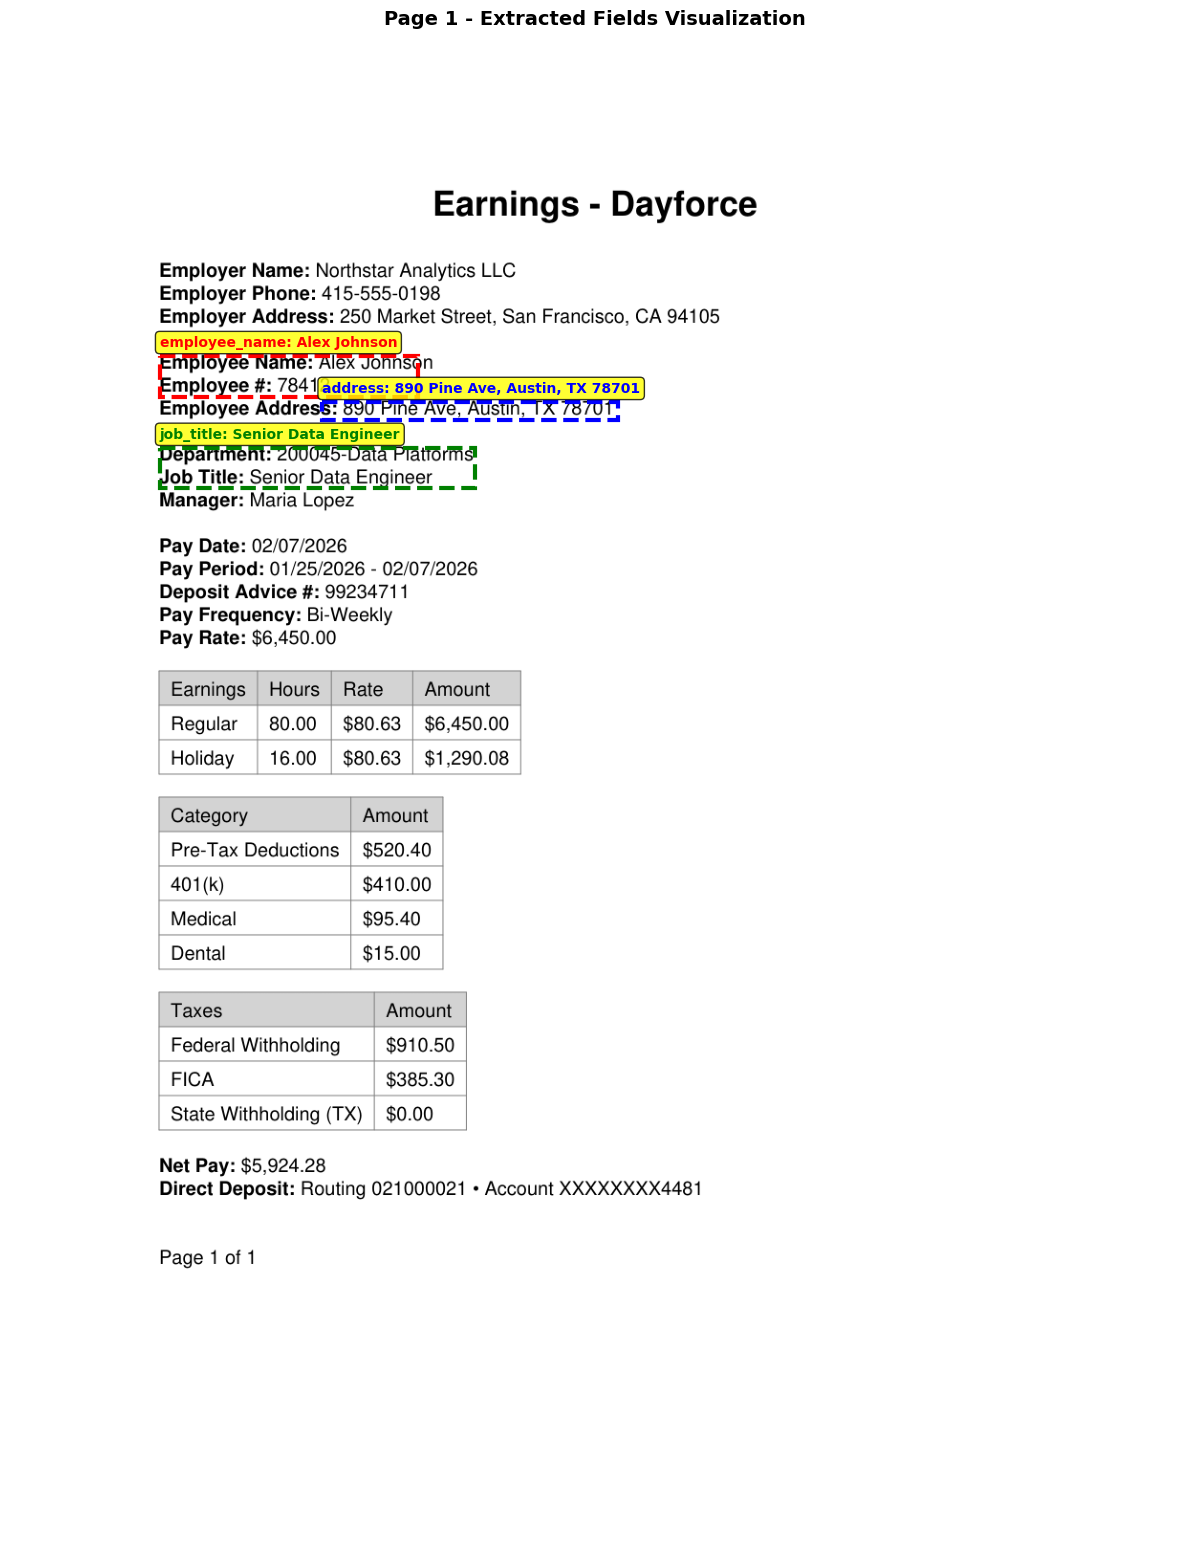

In [13]:
# Visualize the string template extraction results
if result.pages:
    extracted_data = result.pages[0].extracted_data
    
    print("🎯 Finding bounding boxes for string template extracted fields...")
    print(f"\n📋 Extracted fields: {list(extracted_data.keys())}")
    
    # First, we need to convert the document to get layout information
    print("\n📄 Converting document to get bounding box information...")
    conversion_result = doc_converter.convert(file_path)
    
    # Find bounding boxes with improved precision
    field_bboxes = []
    field_labels = []
    
    for field, value in extracted_data.items():
        if not value:
            continue
            
        value_str = str(value)
        
        # Search in document for this specific value
        # We'll look for the smallest text element that contains our value
        best_match = None
        min_length = float('inf')
        
        for item, _ in conversion_result.document.iterate_items():
            if not hasattr(item, 'text') or not hasattr(item, 'prov'):
                continue
            
            # Check if value is in this item's text
            if value_str in item.text:
                # Prefer shorter matches (more precise)
                if len(item.text) < min_length:
                    min_length = len(item.text)
                    
                    if item.prov:
                        for prov in item.prov:
                            if prov.page_no == 1:  # First page only
                                bbox = prov.bbox
                                best_match = {
                                    'text': value_str,
                                    'full_text': item.text,
                                    'page': prov.page_no,
                                    'bbox': {
                                        'l': bbox.l,
                                        't': bbox.t,
                                        'r': bbox.r,
                                        'b': bbox.b,
                                        'coord_origin': bbox.coord_origin
                                    }
                                }
        
        if best_match:
            field_bboxes.append(best_match)
            field_labels.append(f"{field}: {value}")
            print(f"  ✓ Found '{value}' in text: '{best_match['full_text'][:60]}...'")
        else:
            print(f"  ⚠️ Could not find bbox for '{value}' (field: {field})")
    
    if field_bboxes:
        print(f"\n🎨 Visualizing {len(field_bboxes)} extracted fields:")
        try:
            draw_bounding_boxes_on_page(
                file_path,
                field_bboxes,
                labels=field_labels,
                output_path=data_dir / "earnings_string_template_bbox.png"
            )
        except Exception as e:
            print(f"⚠️ Visualization error: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\n⚠️ No bounding boxes found for extracted values")
else:
    print("⚠️ No extraction results available")

### Using pydantic

In [14]:
from pydantic import BaseModel, Field
from typing import Optional
from rich import print as rprint

# Define a FLAT Pydantic model for earnings statement metadata
# The extractor returns a flat structure, not nested objects

class EarningsStatement(BaseModel):
    """Complete earnings statement metadata model - flat structure"""
    
    # Employer Information
    employer_name: Optional[str] = Field(
        default=None,
        examples=["TechCorp Industries", "Global Finance Solutions", "Pacific Retail Group"]
    )
    employer_phone: Optional[str] = Field(
        default=None,
        examples=["206-555-0123", "512-555-9876", "312-555-4567"]
    )
    employer_address: Optional[str] = Field(
        default=None,
        examples=[
            "1500 Broadway, New York, NY 10036",
            "3000 Tech Drive, Seattle, WA 98101",
            "500 Commerce Blvd, Chicago, IL 60601"
        ]
    )
    
    # Employee Information
    employee_name: Optional[str] = Field(
        default=None,
        examples=["Sarah Chen", "Michael Rodriguez", "Emily Williams"]
    )
    employee_number: Optional[str] = Field(
        default=None,
        examples=["12345", "98765", "54321"],
        alias="employee_#"
    )
    employee_address: Optional[str] = Field(
        default=None,
        examples=[
            "123 Oak Street, Portland, OR 97201",
            "456 Elm Avenue, Denver, CO 80202",
            "789 Maple Lane, Boston, MA 02101"
        ]
    )
    department: Optional[str] = Field(
        default=None,
        examples=["100025-Engineering", "300015-Sales Operations", "400012-Finance"]
    )
    job_title: Optional[str] = Field(
        default=None,
        examples=["Software Architect", "Product Manager", "Financial Analyst"]
    )
    manager: Optional[str] = Field(
        default=None,
        examples=["David Kim", "Jennifer Brown", "Robert Taylor"]
    )
    
    # Payroll Details
    pay_date: Optional[str] = Field(
        default=None,
        examples=["03/15/2026", "04/01/2026", "05/30/2026"]
    )
    pay_period: Optional[str] = Field(
        default=None,
        examples=[
            "03/01/2026 - 03/15/2026",
            "03/16/2026 - 03/31/2026",
            "04/01/2026 - 04/15/2026"
        ]
    )
    deposit_advice_number: Optional[str] = Field(
        default=None,
        examples=["88123456", "77654321", "66789012"],
        alias="deposit_advice_#"
    )
    pay_frequency: Optional[str] = Field(
        default=None,
        examples=["Weekly", "Monthly", "Semi-Monthly"]
    )
    pay_rate: Optional[str] = Field(
        default=None,
        examples=["$4,800.00", "$7,200.00", "$5,500.00"]
    )
    
    # Earnings
    regular_pay_hours: Optional[float] = Field(
        default=None,
        examples=[40.0, 160.0, 88.0]
    )
    regular_pay_rate: Optional[str] = Field(
        default=None,
        examples=["$65.50", "$92.00", "$75.25"]
    )
    regular_pay_amount: Optional[str] = Field(
        default=None,
        examples=["$5,200.00", "$7,360.00", "$6,020.00"]
    )
    holiday_pay_hours: Optional[float] = Field(
        default=None,
        examples=[8.0, 24.0, 12.0]
    )
    holiday_pay_rate: Optional[str] = Field(
        default=None,
        examples=["$65.50", "$92.00", "$75.25"]
    )
    holiday_pay_amount: Optional[str] = Field(
        default=None,
        examples=["$524.00", "$2,208.00", "$903.00"]
    )
    
    # Pre-Tax Deductions
    total_pretax_deductions: Optional[str] = Field(
        default=None,
        examples=["$650.75", "$890.25", "$420.50"]
    )
    retirement_401k: Optional[str] = Field(
        default=None,
        examples=["$500.00", "$750.00", "$325.00"],
        alias="401(k)"
    )
    medical: Optional[str] = Field(
        default=None,
        examples=["$125.50", "$185.00", "$75.00"]
    )
    dental: Optional[str] = Field(
        default=None,
        examples=["$25.00", "$35.00", "$20.00"]
    )
    
    # Taxes
    federal_withholding: Optional[str] = Field(
        default=None,
        examples=["$1,250.00", "$1,850.00", "$675.00"]
    )
    fica: Optional[str] = Field(
        default=None,
        examples=["$450.00", "$625.00", "$320.00"]
    )
    state_withholding: Optional[str] = Field(
        default=None,
        examples=["$250.00", "$425.00", "$180.00"]
    )
    
    # Net Pay
    net_pay: Optional[str] = Field(
        default=None,
        examples=["$4,125.50", "$6,850.75", "$3,920.00"]
    )
    
    # Distribution
    bank_routing_number: Optional[str] = Field(
        default=None,
        examples=["011000015", "121000248", "026009593"],
        alias="bank_routing_#"
    )
    bank_account_number: Optional[str] = Field(
        default=None,
        examples=["XXXXXXXX1234", "XXXXXXXX5678", "XXXXXXXX9012"],
        alias="bank_account_#"
    )
    
    # System Info
    platform: Optional[str] = Field(
        default=None,
        examples=["Payroll - ADP", "Earnings - Workday", "Compensation - Paychex"]
    )
    
    model_config = {"populate_by_name": True}

# Extract using Pydantic model
earnings_file_path = str(data_dir / "sample_earnings.pdf")

result = extractor.extract(
    source=earnings_file_path,
    template=EarningsStatement,
)

print("📋 Earnings Statement Pydantic Model Extraction Results:\n")
rprint(result.pages)

# Validate and load with Pydantic
if result.pages:
    earnings_statement = EarningsStatement.model_validate(result.pages[0].extracted_data)
    print(f"\n✅ Validated Earnings Statement Object:")
    rprint(earnings_statement)
    
    # Display specific fields
    print(f"\n👤 Employee: {earnings_statement.employee_name}")
    print(f"   Employee #: {earnings_statement.employee_number}")
    print(f"   Job Title: {earnings_statement.job_title}")
    print(f"   Department: {earnings_statement.department}")
    print(f"   Manager: {earnings_statement.manager}")
    
    print(f"\n🏢 Employer: {earnings_statement.employer_name}")
    print(f"   Phone: {earnings_statement.employer_phone}")
    print(f"   Address: {earnings_statement.employer_address}")
    
    print(f"\n💰 Payroll:")
    print(f"   Pay Period: {earnings_statement.pay_period}")
    print(f"   Pay Date: {earnings_statement.pay_date}")
    print(f"   Pay Frequency: {earnings_statement.pay_frequency}")
    print(f"   Pay Rate: {earnings_statement.pay_rate}")
    
    print(f"\n💵 Earnings:")
    print(f"   Regular Hours: {earnings_statement.regular_pay_hours}")
    print(f"   Regular Amount: {earnings_statement.regular_pay_amount}")
    print(f"   Holiday Hours: {earnings_statement.holiday_pay_hours}")
    print(f"   Holiday Amount: {earnings_statement.holiday_pay_amount}")
    
    print(f"\n📉 Deductions:")
    print(f"   401(k): {earnings_statement.retirement_401k}")
    print(f"   Medical: {earnings_statement.medical}")
    print(f"   Dental: {earnings_statement.dental}")
    print(f"   Total Pre-Tax: {earnings_statement.total_pretax_deductions}")
    
    print(f"\n💸 Taxes:")
    print(f"   Federal: {earnings_statement.federal_withholding}")
    print(f"   FICA: {earnings_statement.fica}")
    print(f"   State: {earnings_statement.state_withholding}")
    
    print(f"\n✅ Net Pay: {earnings_statement.net_pay}")
    
    print(f"\n🏦 Distribution:")
    print(f"   Routing #: {earnings_statement.bank_routing_number}")
    print(f"   Account #: {earnings_statement.bank_account_number}")

# Extract with custom instance defaults
result_with_defaults = extractor.extract(
    source=earnings_file_path,
    template=EarningsStatement(
        employer_name="UNKNOWN EMPLOYER",
        employee_name="UNKNOWN EMPLOYEE",
        employee_number="00000",
        pay_date="01/01/2026",
        net_pay="$0.00"
    ),
)

print("\n\n📋 Extraction with Instance Defaults:\n")
rprint(result_with_defaults.pages)

if result_with_defaults.pages:
    earnings_with_defaults = EarningsStatement.model_validate(
        result_with_defaults.pages[0].extracted_data
    )
    print(f"\n✓ Employee: {earnings_with_defaults.employee_name} (extracted or default)")
    print(f"✓ Pay Date: {earnings_with_defaults.pay_date} (extracted or default)")
    print(f"✓ Net Pay: {earnings_with_defaults.net_pay} (extracted or default)")

c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\docling\document_extractor.py:145: UserWarning: The extract API is currently experimental and may change without prior notice.
Only PDF and image formats are supported.
  return next(all_res)
2026-01-14 20:52:21,658 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 20:52:21,658 - INFO - Going to extract document batch...
2026-01-14 20:52:21,658 - INFO - Processing pages 1-9223372036854775807 of 1 total pages for extraction
2026-01-14 20:52:36,665 - INFO - Finished extracting document sample_earnings.pdf in 15.00 sec.


📋 Earnings Statement Pydantic Model Extraction Results:



[
    ExtractedPageData(
        page_no=1,
        extracted_data={
            'employer_name': 'Northstar Analytics LLC',
            'employer_phone': '415-555-0198',
            'employer_address': '250 Market Street, San Francisco, CA 94105',
            'employee_name': 'Alex Johnson',
            'employee_number': '78412',
            'employee_address': '890 Pine Ave, Austin, TX 78701',
            'department': '200045-Data Platforms',
            'job_title': 'Senior Data Engineer',
            'manager': 'Maria Lopez',
            'pay_date': '2026-02-07',
            'pay_period': '2026-01-25 to 2026-02-07',
            'deposit_advice_number': '99234711',
            'pay_frequency': 'Bi-Weekly',
            'pay_rate': '$6,450.00',
            'regular_pay_hours': '80.00',
            'regular_pay_rate': '$80.63',
            'regular_pay_amount': '$6,450.00',
            'holiday_pay_hours': '16.00',
            'holiday_pay_rate': '$80.63',
            'holiday_pay_amount': '$1,290.08',
            'total_pretax_deductions': '$520.40',
            'retirement_401k': '$410.00',
            'medical': '$95.40',
            'dental': '$15.00',
            'federal_withholding': '$910.50',
            'fica': '$385.30',
            'state_withholding': '$0.00',
            'net_pay': '$5,924.28',
            'bank_routing_number': '021000021',
            'bank_account_number': 'XXXXXXX4481',
            'platform': 'Dayforce'
        },
        raw_text='{"employer_name": "Northstar Analytics LLC", "employer_phone": "415-555-0198", 
"employer_address": "250 Market Street, San Francisco, CA 94105", "employee_name": "Alex Johnson", 
"employee_number": "78412", "employee_address": "890 Pine Ave, Austin, TX 78701", "department": "200045-Data 
Platforms", "job_title": "Senior Data Engineer", "manager": "Maria Lopez", "pay_date": "2026-02-07", "pay_period": 
"2026-01-25 to 2026-02-07", "deposit_advice_number": "99234711", "pay_frequency": "Bi-Weekly", "pay_rate": 
"$6,450.00", "regular_pay_hours": "80.00", "regular_pay_rate": "$80.63", "regular_pay_amount": "$6,450.00", 
"holiday_pay_hours": "16.00", "holiday_pay_rate": "$80.63", "holiday_pay_amount": "$1,290.08", 
"total_pretax_deductions": "$520.40", "retirement_401k": "$410.00", "medical": "$95.40", "dental": "$15.00", 
"federal_withholding": "$910.50", "fica": "$385.30", "state_withholding": "$0.00", "net_pay": "$5,924.28", 
"bank_routing_number": "021000021", "bank_account_number": "XXXXXXX4481", "platform": "Dayforce"}',
        errors=[]
    )
]


✅ Validated Earnings Statement Object:


EarningsStatement(
    employer_name='Northstar Analytics LLC',
    employer_phone='415-555-0198',
    employer_address='250 Market Street, San Francisco, CA 94105',
    employee_name='Alex Johnson',
    employee_number='78412',
    employee_address='890 Pine Ave, Austin, TX 78701',
    department='200045-Data Platforms',
    job_title='Senior Data Engineer',
    manager='Maria Lopez',
    pay_date='2026-02-07',
    pay_period='2026-01-25 to 2026-02-07',
    deposit_advice_number='99234711',
    pay_frequency='Bi-Weekly',
    pay_rate='$6,450.00',
    regular_pay_hours=80.0,
    regular_pay_rate='$80.63',
    regular_pay_amount='$6,450.00',
    holiday_pay_hours=16.0,
    holiday_pay_rate='$80.63',
    holiday_pay_amount='$1,290.08',
    total_pretax_deductions='$520.40',
    retirement_401k='$410.00',
    medical='$95.40',
    dental='$15.00',
    federal_withholding='$910.50',
    fica='$385.30',
    state_withholding='$0.00',
    net_pay='$5,924.28',
    bank_routing_number='021000021',
    bank_account_number='XXXXXXX4481',
    platform='Dayforce'
)

c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\docling\document_extractor.py:145: UserWarning: The extract API is currently experimental and may change without prior notice.
Only PDF and image formats are supported.
  return next(all_res)
2026-01-14 20:52:36,674 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 20:52:36,674 - INFO - Going to extract document batch...
2026-01-14 20:52:36,675 - INFO - Processing pages 1-9223372036854775807 of 1 total pages for extraction



👤 Employee: Alex Johnson
   Employee #: 78412
   Job Title: Senior Data Engineer
   Department: 200045-Data Platforms
   Manager: Maria Lopez

🏢 Employer: Northstar Analytics LLC
   Phone: 415-555-0198
   Address: 250 Market Street, San Francisco, CA 94105

💰 Payroll:
   Pay Period: 2026-01-25 to 2026-02-07
   Pay Date: 2026-02-07
   Pay Frequency: Bi-Weekly
   Pay Rate: $6,450.00

💵 Earnings:
   Regular Hours: 80.0
   Regular Amount: $6,450.00
   Holiday Hours: 16.0
   Holiday Amount: $1,290.08

📉 Deductions:
   401(k): $410.00
   Medical: $95.40
   Dental: $15.00
   Total Pre-Tax: $520.40

💸 Taxes:
   Federal: $910.50
   FICA: $385.30
   State: $0.00

✅ Net Pay: $5,924.28

🏦 Distribution:
   Routing #: 021000021
   Account #: XXXXXXX4481


2026-01-14 20:52:50,663 - INFO - Finished extracting document sample_earnings.pdf in 13.98 sec.




📋 Extraction with Instance Defaults:



[
    ExtractedPageData(
        page_no=1,
        extracted_data={
            'employer_name': 'Northstar Analytics LLC',
            'employer_phone': '415-555-0198',
            'employer_address': '250 Market Street, San Francisco, CA 94105',
            'employee_name': 'Alex Johnson',
            'employee_number': '78412',
            'employee_address': '890 Pine Ave, Austin, TX 78701',
            'department': '200045-Data Platforms',
            'job_title': 'Senior Data Engineer',
            'manager': 'Maria Lopez',
            'pay_date': '2026-02-07',
            'pay_period': '2026-01-25 to 2026-02-07',
            'deposit_advice_number': '99234711',
            'pay_frequency': 'Bi-Weekly',
            'pay_rate': '$6,450.00',
            'regular_pay_hours': 80.0,
            'regular_pay_rate': '$80.63',
            'regular_pay_amount': '$6,450.00',
            'holiday_pay_hours': 16.0,
            'holiday_pay_rate': '$80.63',
            'holiday_pay_amount': '$1,290.08',
            'total_pretax_deductions': '$520.4',
            'retirement_401k': '$410.0',
            'medical': '$95.4',
            'dental': '$15.0',
            'federal_withholding': '$910.5',
            'fica': '$385.3',
            'state_withholding': '$0.0',
            'net_pay': '$5,924.28',
            'bank_routing_number': '021000021',
            'bank_account_number': 'XXXXXXX4481',
            'platform': 'Dayforce'
        },
        raw_text='{"employer_name": "Northstar Analytics LLC", "employer_phone": "415-555-0198", 
"employer_address": "250 Market Street, San Francisco, CA 94105", "employee_name": "Alex Johnson", 
"employee_number": "78412", "employee_address": "890 Pine Ave, Austin, TX 78701", "department": "200045-Data 
Platforms", "job_title": "Senior Data Engineer", "manager": "Maria Lopez", "pay_date": "2026-02-07", "pay_period": 
"2026-01-25 to 2026-02-07", "deposit_advice_number": "99234711", "pay_frequency": "Bi-Weekly", "pay_rate": 
"$6,450.00", "regular_pay_hours": 80.0, "regular_pay_rate": "$80.63", "regular_pay_amount": "$6,450.00", 
"holiday_pay_hours": 16.0, "holiday_pay_rate": "$80.63", "holiday_pay_amount": "$1,290.08", 
"total_pretax_deductions": "$520.4", "retirement_401k": "$410.0", "medical": "$95.4", "dental": "$15.0", 
"federal_withholding": "$910.5", "fica": "$385.3", "state_withholding": "$0.0", "net_pay": "$5,924.28", 
"bank_routing_number": "021000021", "bank_account_number": "XXXXXXX4481", "platform": "Dayforce"}',
        errors=[]
    )
]


✓ Employee: Alex Johnson (extracted or default)
✓ Pay Date: 2026-02-07 (extracted or default)
✓ Net Pay: $5,924.28 (extracted or default)


#### 📊 Visualize Pydantic Extracted Fields

Let's visualize key fields from the earnings statement extraction.

2026-01-14 20:53:28,174 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 20:53:28,176 - INFO - Going to convert document batch...
2026-01-14 20:53:28,177 - INFO - Processing document sample_earnings.pdf


🎯 Finding bounding boxes for Pydantic model extracted fields...

📋 Visualizing fields: ['employee_name', 'employee_number', 'job_title', 'pay_date', 'pay_rate', 'net_pay', 'regular_pay_amount', 'total_pretax_deductions']

📄 Converting document to get bounding box information...


2026-01-14 20:53:29,152 - INFO - Finished converting document sample_earnings.pdf in 0.97 sec.


  ✓ Found 'Alex Johnson' for field 'employee_name'
  ✓ Found '78412' for field 'employee_number'
  ✓ Found 'Senior Data Engineer' for field 'job_title'
  ⚠️ Could not find bbox for '2026-02-07' (field: pay_date)
  ✓ Found '$6,450.00' for field 'pay_rate'
  ✓ Found '$5,924.28' for field 'net_pay'
  ✓ Found '$6,450.00' for field 'regular_pay_amount'
  ⚠️ Could not find bbox for '$520.40' (field: total_pretax_deductions)

🎨 Visualizing 6 key fields from Pydantic model:
✓ Saved annotated image to: mock_data_extraction\earnings_pydantic_extraction_bbox.png


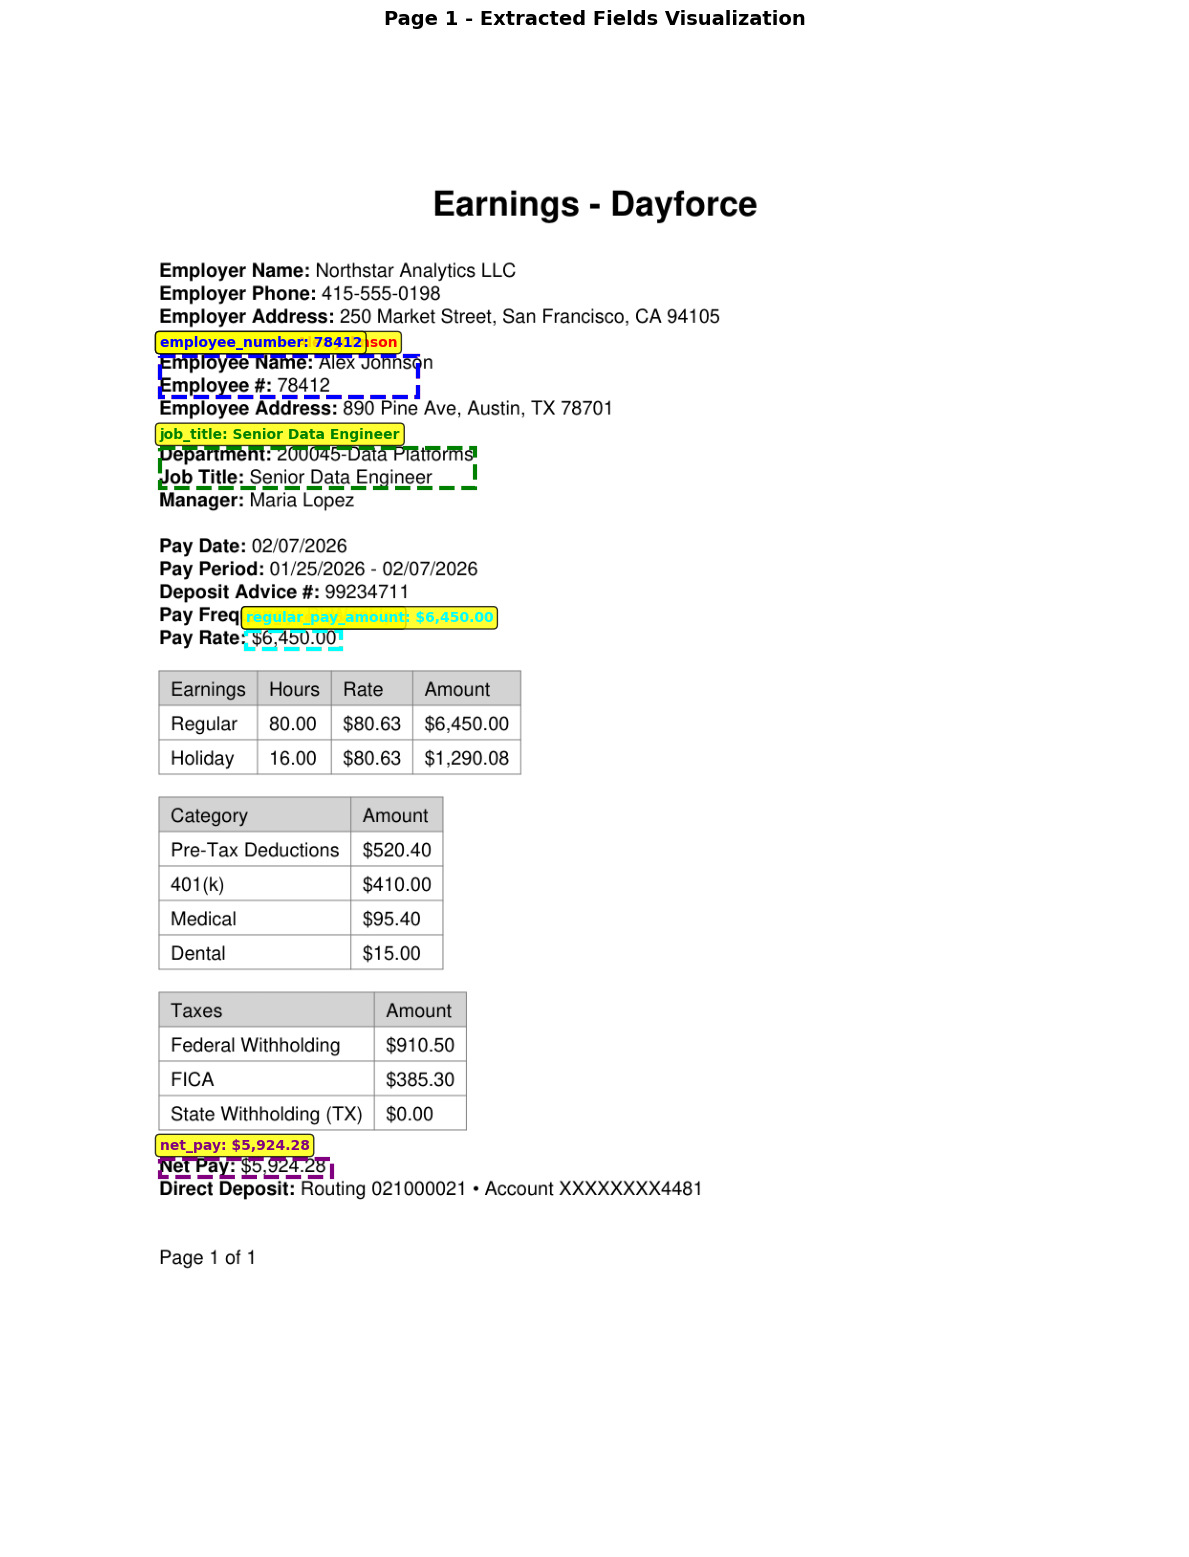

In [16]:
# Visualize key fields from the Pydantic model extraction
if result.pages:
    pydantic_extracted = result.pages[0].extracted_data
    
    print("🎯 Finding bounding boxes for Pydantic model extracted fields...")
    
    # Select key fields to visualize (limit to avoid overcrowding)
    key_fields = [
        'employee_name', 'employee_number', 'job_title', 
        'pay_date', 'pay_rate', 'net_pay',
        'regular_pay_amount', 'total_pretax_deductions'
    ]
    
    # Also include aliased fields
    alias_mapping = {
        'employee_#': 'employee_number',
        'deposit_advice_#': 'deposit_advice_number',
        '401(k)': 'retirement_401k',
        'bank_routing_#': 'bank_routing_number',
        'bank_account_#': 'bank_account_number'
    }
    
    print(f"\n📋 Visualizing fields: {key_fields}")
    
    # Convert the document to get layout information
    print("\n📄 Converting document to get bounding box information...")
    pydantic_conversion = doc_converter.convert(earnings_file_path)
    
    # Find bounding boxes for key fields
    pydantic_bboxes = []
    pydantic_labels = []
    
    for field in key_fields:
        # Check both the field name and any aliases
        value = pydantic_extracted.get(field)
        if not value:
            # Check aliases
            for alias, original in alias_mapping.items():
                if original == field:
                    value = pydantic_extracted.get(alias)
                    if value:
                        break
        
        if not value:
            continue
        
        value_str = str(value)
        
        # Search for smallest text element containing this value
        best_match = None
        min_length = float('inf')
        
        for item, _ in pydantic_conversion.document.iterate_items():
            if not hasattr(item, 'text') or not hasattr(item, 'prov'):
                continue
            
            # Check if value is in this item's text
            if value_str in item.text:
                # Prefer shorter matches (more precise)
                if len(item.text) < min_length:
                    min_length = len(item.text)
                    
                    if item.prov:
                        for prov in item.prov:
                            if prov.page_no == 1:  # First page only
                                bbox = prov.bbox
                                best_match = {
                                    'text': value_str,
                                    'full_text': item.text,
                                    'page': prov.page_no,
                                    'bbox': {
                                        'l': bbox.l,
                                        't': bbox.t,
                                        'r': bbox.r,
                                        'b': bbox.b,
                                        'coord_origin': bbox.coord_origin
                                    }
                                }
        
        if best_match:
            pydantic_bboxes.append(best_match)
            # Truncate long values for labels
            display_value = value_str if len(value_str) < 25 else value_str[:22] + "..."
            pydantic_labels.append(f"{field}: {display_value}")
            print(f"  ✓ Found '{value_str}' for field '{field}'")
        else:
            print(f"  ⚠️ Could not find bbox for '{value_str}' (field: {field})")
    
    if pydantic_bboxes:
        print(f"\n🎨 Visualizing {len(pydantic_bboxes)} key fields from Pydantic model:")
        try:
            draw_bounding_boxes_on_page(
                earnings_file_path,
                pydantic_bboxes,
                labels=pydantic_labels,
                output_path=data_dir / "earnings_pydantic_extraction_bbox.png"
            )
        except Exception as e:
            print(f"⚠️ Visualization error: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\n⚠️ No bounding boxes found for Pydantic extracted fields")
else:
    print("⚠️ No Pydantic extraction results available")

# VLM Based
- Require GPUs
- very slow on cpu based

## Extraction using default VLM
Reference: https://docling-project.github.io/docling/usage/vision_models/

| Model Instance | Model | Framework | Device | Num Pages | Inference Time (sec) |
|---|---|---|---|---|---|
| vlm_model_specs.GRANITEDOCLING_TRANSFORMERS | ibm-granite/granite-docling-258M | Transformers/AutoModelForVision2Seq | MPS | 1 | - |
| vlm_model_specs.GRANITEDOCLING_MLX | ibm-granite/granite-docling-258M-mlx-bf16 | MLX | MPS | 1 | - |
| vlm_model_specs.SMOLDOCLING_TRANSFORMERS | ds4sd/SmolDocling-256M-preview | Transformers/AutoModelForVision2Seq | MPS | 1 | 102.212 |
| vlm_model_specs.SMOLDOCLING_MLX | ds4sd/SmolDocling-256M-preview-mlx-bf16 | MLX | MPS | 1 | 6.15453 |
| vlm_model_specs.QWEN25_VL_3B_MLX | mlx-community/Qwen2.5-VL-3B-Instruct-bf16 | MLX | MPS | 1 | 23.4951 |
| vlm_model_specs.PIXTRAL_12B_MLX | mlx-community/pixtral-12b-bf16 | MLX | MPS | 1 | 308.856 |
| vlm_model_specs.GEMMA3_12B_MLX | mlx-community/gemma-3-12b-it-bf16 | MLX | MPS | 1 | 378.486 |
| vlm_model_specs.GRANITE_VISION_TRANSFORMERS | ibm-granite/granite-vision-3.2-2b | Transformers/AutoModelForVision2Seq | MPS | 1 | 104.75 |
| vlm_model_specs.PHI4_TRANSFORMERS | microsoft/Phi-4-multimodal-instruct | Transformers/AutoModelForCasualLM | CPU | 1 | 1175.67 |
| vlm_model_specs.PIXTRAL_12B_TRANSFORMERS | mistral-community/pixtral-12b | Transformers/AutoModelForVision2Seq | CPU | 1 | 1828.21 |

In [ ]:
from docling.datamodel import vlm_model_specs
from docling.datamodel.pipeline_options import VlmPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from docling.datamodel.base_models import InputFormat
from docling.datamodel.accelerator_options import AcceleratorDevice, AcceleratorOptions

# Available VLM models
print("Available VLM Model Specs:")
print("="*60)

vlm_models = [
    ("GRANITEDOCLING_TRANSFORMERS", vlm_model_specs.GRANITEDOCLING_TRANSFORMERS),
    ("GRANITEDOCLING_MLX", vlm_model_specs.GRANITEDOCLING_MLX),
    ("SMOLDOCLING_TRANSFORMERS", vlm_model_specs.SMOLDOCLING_TRANSFORMERS),
    ("SMOLDOCLING_MLX", vlm_model_specs.SMOLDOCLING_MLX),
    ("QWEN25_VL_3B_MLX", vlm_model_specs.QWEN25_VL_3B_MLX),
    ("PIXTRAL_12B_MLX", vlm_model_specs.PIXTRAL_12B_MLX),
    ("GEMMA3_12B_MLX", vlm_model_specs.GEMMA3_12B_MLX),
    ("GRANITE_VISION_TRANSFORMERS", vlm_model_specs.GRANITE_VISION_TRANSFORMERS),
    ("PHI4_TRANSFORMERS", vlm_model_specs.PHI4_TRANSFORMERS),
    ("PIXTRAL_12B_TRANSFORMERS", vlm_model_specs.PIXTRAL_12B_TRANSFORMERS),
]

for model_name, model_spec in vlm_models:
    print(f"\n📦 {model_name}")
    print(f"   Type: {type(model_spec).__name__}")

try:
    # Get the first model spec (second element of first tuple)
    selected_model = vlm_model_specs.GRANITE_VISION_TRANSFORMERS
    
    pipeline_options = VlmPipelineOptions(vlm_options=selected_model, accelerator_options=AcceleratorOptions(device=AcceleratorDevice.CUDA,))

    # Example: Use a specific model
    print("\n" + "="*60)
    print(f"Converting with {vlm_models[0][0]} Model:")
    print("="*60)
    
    converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(
                pipeline_cls=VlmPipeline,
                pipeline_options=pipeline_options,
            ),
        }
    )
    
    result = converter.convert(data_dir / "sample_earnings.pdf")
    print(f"✅ Conversion Status: {result.status}")
    print(f"\nFirst 300 chars:\n{result.document.export_to_markdown()[:300]}...")
    
except Exception as e:
    print(f"⚠️ Error during conversion: {e}")


2026-01-14 13:11:18,807 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 13:11:18,844 - INFO - Going to convert document batch...
2026-01-14 13:11:18,845 - INFO - Initializing pipeline for VlmPipeline with options hash d015be512df37b4644bed71b1f55da6e
2026-01-14 13:11:18,865 - INFO - Loading plugin 'docling_defaults'
2026-01-14 13:11:18,866 - WARNING - The plugin surya-ocr will not be loaded because Docling is being executed with allow_external_plugins=false.
2026-01-14 13:11:18,868 - INFO - Registered picture descriptions: ['vlm', 'api']


Available VLM Model Specs:

📦 GRANITEDOCLING_TRANSFORMERS
   Type: InlineVlmOptions

📦 GRANITEDOCLING_MLX
   Type: InlineVlmOptions

📦 SMOLDOCLING_TRANSFORMERS
   Type: InlineVlmOptions

📦 SMOLDOCLING_MLX
   Type: InlineVlmOptions

📦 QWEN25_VL_3B_MLX
   Type: InlineVlmOptions

📦 PIXTRAL_12B_MLX
   Type: InlineVlmOptions

📦 GEMMA3_12B_MLX
   Type: InlineVlmOptions

📦 GRANITE_VISION_TRANSFORMERS
   Type: InlineVlmOptions

📦 PHI4_TRANSFORMERS
   Type: InlineVlmOptions

📦 PIXTRAL_12B_TRANSFORMERS
   Type: InlineVlmOptions

Converting with GRANITEDOCLING_TRANSFORMERS Model:


2026-01-14 13:11:21,482 - INFO - Accelerator device: 'cuda:0'


## Extraction using VLM - Qwen for e.g.

In [ ]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import VlmPipelineOptions

try:
    from docling.pipeline.vlm_pipeline import VlmPipeline
    from docling.datamodel.pipeline_options_vlm_model import (
        InlineVlmOptions, 
        ApiVlmOptions,
        InferenceFramework,
        ResponseFormat
    )
    
    # Available VLM Configuration Options
    print("✅ VLM Features Available!")
    print("="*60)
    print("Available Inference Frameworks:")
    for fw in InferenceFramework:
        print(f"  - {fw.name}: {fw.value}")
    
    print("\nAvailable Response Formats:")
    for fmt in ResponseFormat:
        print(f"  - {fmt.name}: {fmt.value}")
    
    # Example: Create a VLM configuration for local model inference
    print("\n" + "="*60)
    print("Creating VLM Configuration Example:")
    print("="*60)
    
    # Create InlineVlmOptions with required parameters
    # https://docling-project.github.io/docling/usage/vision_models/
    vlm_config = InlineVlmOptions(
        repo_id="Qwen/Qwen2-VL-2B-Instruct",
        prompt="Analyze this document and extract key information.",
        inference_framework=InferenceFramework.TRANSFORMERS,
        response_format=ResponseFormat.MARKDOWN
    )
    
    print(f"✅ VLM Configuration Created:")
    print(f"   Model: {vlm_config.repo_id}")
    print(f"   Framework: {vlm_config.inference_framework.value}")
    print(f"   Response Format: {vlm_config.response_format.value}")
    
    # Setup VLM pipeline options
    pipeline_options = VlmPipelineOptions(
        vlm_options=vlm_config
    )
    
    print(f"\n✅ VlmPipelineOptions configured successfully")
    
    # Note: To use with actual PDF conversion:
    converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(
                pipeline_cls=VlmPipeline,
                pipeline_options=pipeline_options
            )
        }
    )
    result = converter.convert(data_dir / "sample_earnings.pdf")
    print(result.document.export_to_markdown())
    
except ImportError as e:
    print(f"⚠️ VLM features require: pip install docling[vlm]")
    print(f"   Error: {e}")
except Exception as e:
    print(f"⚠️ Error setting up VLM: {type(e).__name__}: {e}")

## Comparing vlm models - Benchmarking code (DO NOT USE UNLESS YOU INTEND TO)
- https://docling-project.github.io/docling/examples/compare_vlm_models/

In [ ]:

import json
import sys
import time
from pathlib import Path

from docling_core.types.doc import DocItemLabel, ImageRefMode
from docling_core.types.doc.document import DEFAULT_EXPORT_LABELS
from tabulate import tabulate

from docling.datamodel import vlm_model_specs
from docling.datamodel.accelerator_options import AcceleratorDevice
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
)
from docling.datamodel.pipeline_options_vlm_model import (
    InferenceFramework,
    InlineVlmOptions,
    ResponseFormat,
    TransformersModelType,
    TransformersPromptStyle,
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline


def convert(sources: list[Path], converter: DocumentConverter):
    # Note: this helper assumes a single-item `sources` list. It returns after
    # processing the first source to keep runtime/output focused.
    model_id = pipeline_options.vlm_options.repo_id.replace("/", "_")
    framework = pipeline_options.vlm_options.inference_framework
    for source in sources:
        print("================================================")
        print("Processing...")
        print(f"Source: {source}")
        print("---")
        print(f"Model: {model_id}")
        print(f"Framework: {framework}")
        print("================================================")
        print("")

        res = converter.convert(source)

        print("")

        fname = f"{res.input.file.stem}-{model_id}-{framework}"

        inference_time = 0.0
        for i, page in enumerate(res.pages):
            inference_time += page.predictions.vlm_response.generation_time
            print("")
            print(
                f" ---------- Predicted page {i} in {pipeline_options.vlm_options.response_format} in {page.predictions.vlm_response.generation_time} [sec]:"
            )
            print(page.predictions.vlm_response.text)
            print(" ---------- ")

        print("===== Final output of the converted document =======")

        # Manual export for illustration. Below, `save_as_json()` writes the same
        # JSON again; kept intentionally to show both approaches.
        with (out_path / f"{fname}.json").open("w") as fp:
            fp.write(json.dumps(res.document.export_to_dict()))

        res.document.save_as_json(
            out_path / f"{fname}.json",
            image_mode=ImageRefMode.PLACEHOLDER,
        )
        print(f" => produced {out_path / fname}.json")

        res.document.save_as_markdown(
            out_path / f"{fname}.md",
            image_mode=ImageRefMode.PLACEHOLDER,
        )
        print(f" => produced {out_path / fname}.md")

        res.document.save_as_html(
            out_path / f"{fname}.html",
            image_mode=ImageRefMode.EMBEDDED,
            labels=[*DEFAULT_EXPORT_LABELS, DocItemLabel.FOOTNOTE],
            split_page_view=True,
        )
        print(f" => produced {out_path / fname}.html")

        pg_num = res.document.num_pages()
        print("")
        print(
            f"Total document prediction time: {inference_time:.2f} seconds, pages: {pg_num}"
        )
        print("====================================================")

        return [
            source,
            model_id,
            str(framework),
            pg_num,
            inference_time,
        ]


if __name__ == "__main__":
    sources = [
        data_dir / "sample_earnings.pdf",
    ]

    out_path = Path("scratch")
    out_path.mkdir(parents=True, exist_ok=True)

    ## Definiton of more inline models
    llava_qwen = InlineVlmOptions(
        repo_id="llava-hf/llava-interleave-qwen-0.5b-hf",
        # prompt="Read text in the image.",
        prompt="Convert this page to markdown. Do not miss any text and only output the bare markdown!",
        # prompt="Parse the reading order of this document.",
        response_format=ResponseFormat.MARKDOWN,
        inference_framework=InferenceFramework.TRANSFORMERS,
        transformers_model_type=TransformersModelType.AUTOMODEL_IMAGETEXTTOTEXT,
        supported_devices=[
            AcceleratorDevice.CUDA,
            AcceleratorDevice.CPU,
            AcceleratorDevice.XPU,
        ],
        scale=2.0,
        temperature=0.0,
    )

    # Note that this is not the expected way of using the Dolphin model, but it shows the usage of a raw prompt.
    dolphin_oneshot = InlineVlmOptions(
        repo_id="ByteDance/Dolphin",
        prompt="Read text in the image. ",
        response_format=ResponseFormat.MARKDOWN,
        inference_framework=InferenceFramework.TRANSFORMERS,
        transformers_model_type=TransformersModelType.AUTOMODEL_IMAGETEXTTOTEXT,
        transformers_prompt_style=TransformersPromptStyle.RAW,
        supported_devices=[
            AcceleratorDevice.CUDA,
            AcceleratorDevice.CPU,
            AcceleratorDevice.XPU,
        ],
        scale=2.0,
        temperature=0.0,
    )

    ## Use VlmPipeline
    pipeline_options = VlmPipelineOptions()
    pipeline_options.generate_page_images = True

    ## On GPU systems, enable flash_attention_2 with CUDA:
    # pipeline_options.accelerator_options.device = AcceleratorDevice.CUDA
    # pipeline_options.accelerator_options.cuda_use_flash_attention2 = True

    vlm_models = [
        ## DocTags / SmolDocling models
        vlm_model_specs.SMOLDOCLING_MLX,
        vlm_model_specs.SMOLDOCLING_TRANSFORMERS,
        ## Markdown models (using MLX framework)
        vlm_model_specs.QWEN25_VL_3B_MLX,
        vlm_model_specs.PIXTRAL_12B_MLX,
        vlm_model_specs.GEMMA3_12B_MLX,
        ## Markdown models (using Transformers framework)
        vlm_model_specs.GRANITE_VISION_TRANSFORMERS,
        vlm_model_specs.PHI4_TRANSFORMERS,
        vlm_model_specs.PIXTRAL_12B_TRANSFORMERS,
        ## More inline models
        dolphin_oneshot,
        llava_qwen,
    ]

    # Remove MLX models if not on Mac
    if sys.platform != "darwin":
        vlm_models = [
            m for m in vlm_models if m.inference_framework != InferenceFramework.MLX
        ]

    rows = []
    for vlm_options in vlm_models:
        pipeline_options.vlm_options = vlm_options

        ## Set up pipeline for PDF or image inputs
        converter = DocumentConverter(
            format_options={
                InputFormat.PDF: PdfFormatOption(
                    pipeline_cls=VlmPipeline,
                    pipeline_options=pipeline_options,
                ),
                InputFormat.IMAGE: PdfFormatOption(
                    pipeline_cls=VlmPipeline,
                    pipeline_options=pipeline_options,
                ),
            },
        )

        row = convert(sources=sources, converter=converter)
        rows.append(row)

        print(
            tabulate(
                rows, headers=["source", "model_id", "framework", "num_pages", "time"]
            )
        )

        print("see if memory gets released ...")
        time.sleep(10)

C:\Users\pmacharla\AppData\Local\Temp\ipykernel_15180\3856636085.py:180: DeprecationWarning: Using DoclingParseV4DocumentBackend for InputFormat.IMAGE is deprecated. Images should use ImageDocumentBackend via ImageFormatOption. Automatically correcting the backend, please update your code to avoid this warning.
  converter = DocumentConverter(
2026-01-14 11:16:25,015 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2026-01-14 11:16:25,066 - INFO - Going to convert document batch...
2026-01-14 11:16:25,066 - INFO - Initializing pipeline for VlmPipeline with options hash b2e6f171be3db5548e0643814993bbf2
2026-01-14 11:16:25,090 - INFO - Loading plugin 'docling_defaults'
2026-01-14 11:16:25,091 - WARNING - The plugin surya-ocr will not be loaded because Docling is being executed with allow_external_plugins=false.
2026-01-14 11:16:25,091 - INFO - Registered picture descriptions: ['vlm', 'api']


Processing...
Source: mock_data_extraction\sample_earnings.pdf
---
Model: docling-project_SmolDocling-256M-preview
Framework: InferenceFramework.TRANSFORMERS



2026-01-14 11:16:28,268 - INFO - Accelerator device: 'cuda:0'
